In [ ]:
!pip install vaderSentiment
!pip install textblob
!pip install pivottablejs
!pip install scikit-plot

In [ ]:
import pandas as pd
import numpy as np
from textblob import TextBlob
import re
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from scikitplot.metrics import plot_confusion_matrix
import pickle

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import callbacks, layers

import pandas as pd
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification
from tqdm import tqdm

In [ ]:
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import LSTM,Conv1D,Conv2D,MaxPooling2D,MaxPooling1D,Flatten
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler,MinMaxScaler
import seaborn as sns
from tensorflow.keras.layers import LSTM, Bidirectional
from keras.regularizers import l2
seed=42

In [ ]:
import pandas as pd
df = pd.read_csv('/content/FinaDatawithClassification.csv')
# df.drop(['Unnamed: 0'], axis=1, inplace=True)

In [ ]:
df

,date,Open,High,Low,Close,Adj Close,Volume,P_mean,P_sum,count,sentiment_analysis,label
0,2010-12-21,11478.360352,11549.120117,11478.290039,11533.160156,11533.160156,119420000.0,1.000000,1.0,1.0,pos,0
1,2010-12-22,11532.169922,11566.990234,11528.080078,11559.490234,11559.490234,122040000.0,0.500000,2.0,4.0,pos,1
2,2010-12-23,11559.110352,11580.839844,11542.620117,11573.490234,11573.490234,100840000.0,0.000000,0.0,0.0,nue,1
3,2010-12-27,11572.809570,11573.190430,11518.440430,11555.030273,11555.030273,76820000.0,-1.000000,-1.0,1.0,neg,-1
4,2010-12-28,11554.799805,11591.129883,11541.139648,11575.540039,11575.540039,114100000.0,0.333333,1.0,3.0,pos,1
...,...,...,...,...,...,...,...,...,...,...,...,...
3191,2023-08-28,34441.640625,34652.910156,34441.640625,34559.980469,34559.980469,224640000.0,-1.000000,-1.0,1.0,neg,1
3192,2023-08-29,34531.121094,34864.421875,34531.121094,34852.671875,34852.671875,262550000.0,0.500000,1.0,2.0,pos,1
3193,2023-08-30,34847.800781,35025.570312,34811.738281,34890.238281,34890.238281,236070000.0,0.000000,0.0,0.0,nue,1
3194,2023-08-31,34909.089844,35070.210938,34719.769531,34721.910156,34721.910156,341900000.0,0.000000,0.0,0.0,nue,-1


In [ ]:
# P_mean is the sentiment label for the news
# label is the output (the prices went up or down or stayed the same)
df = df[['Open','High','Low','Adj Close','Volume','P_mean', 'label']]
df

,Open,High,Low,Adj Close,Volume,P_mean,label
0,11478.360352,11549.120117,11478.290039,11533.160156,119420000.0,1.000000,0
1,11532.169922,11566.990234,11528.080078,11559.490234,122040000.0,0.500000,1
2,11559.110352,11580.839844,11542.620117,11573.490234,100840000.0,0.000000,1
3,11572.809570,11573.190430,11518.440430,11555.030273,76820000.0,-1.000000,-1
4,11554.799805,11591.129883,11541.139648,11575.540039,114100000.0,0.333333,1
...,...,...,...,...,...,...,...
3191,34441.640625,34652.910156,34441.640625,34559.980469,224640000.0,-1.000000,1
3192,34531.121094,34864.421875,34531.121094,34852.671875,262550000.0,0.500000,1
3193,34847.800781,35025.570312,34811.738281,34890.238281,236070000.0,0.000000,1
3194,34909.089844,35070.210938,34719.769531,34721.910156,341900000.0,0.000000,-1


In [ ]:
#First we made 3 labels: "Up":1, "Down":-1, "No change":0
#But then we've seen that the model performs better with two labels: "Up or no change":1, "Down":-1
# especially that there're only 4 days when the price didn't change
df['label'] = df['label'].replace(0,1)

<ipython-input-9-1939adfc4e91>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['label'] = df['label'].replace(0,1)


In [ ]:
df.corr()

,Open,High,Low,Adj Close,Volume,P_mean,label
Open,1.000000,0.999851,0.999780,0.999635,0.649091,0.010418,-0.005286
High,0.999851,1.000000,0.999713,0.999803,0.652622,0.011450,0.002754
Low,0.999780,0.999713,1.000000,0.999826,0.642785,0.012989,0.005336
Adj Close,0.999635,0.999803,0.999826,1.000000,0.647146,0.013524,0.011762
Volume,0.649091,0.652622,0.642785,0.647146,1.000000,-0.021578,-0.036003
P_mean,0.010418,0.011450,0.012989,0.013524,-0.021578,1.000000,0.151124
label,-0.005286,0.002754,0.005336,0.011762,-0.036003,0.151124,1.000000


In [ ]:

data = df.values

# Empty lists to be populated using formatted training data
trainX = []
trainY = []

n_future = 1  # Number of days we want to look into the future based on the past days
n_past = 10  # Number of past days we want to use to predict the future

# Reformat input data into a shape: (n_samples x timesteps x n_features)
for i in range(n_past, len(data) - n_future + 1):
    trainX.append(data[i - n_past:i, :-1])  # All columns except the last (label)
    trainY.append(data[i + n_future - 1, -1])  # Only the last column (label)

trainX, trainY = np.array(trainX), np.array(trainY)

print('TrainX shape = {}.'.format(trainX.shape))
print('TrainY shape = {}.'.format(trainY.shape))

# Normalize the features
scaler = MinMaxScaler()
num_samples, timesteps, num_features = trainX.shape
trainX = trainX.reshape(-1, num_features)
trainX = scaler.fit_transform(trainX)
trainX = trainX.reshape(num_samples, timesteps, num_features)

# Convert labels from -1 and 1 to 0 and 1
trainY = np.where(trainY == -1, 0, trainY)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(trainX, trainY, test_size=0.2, random_state=42)

input_shape = (X_train.shape[1], X_train.shape[2])  # (timesteps, n_features)

# Model definition
cnn_lstm_model = Sequential()

cnn_lstm_model.add(Conv1D(filters=128, kernel_size=1, strides=1, padding='valid', input_shape=input_shape))
cnn_lstm_model.add(MaxPooling1D(pool_size=1, strides=1))
# cnn_lstm_model.add(Dropout(0.3))

cnn_lstm_model.add(Conv1D(filters=128, kernel_size=1, strides=1, padding='valid', kernel_regularizer=l2(0.01)))
cnn_lstm_model.add(MaxPooling1D(pool_size=1, strides=1))

cnn_lstm_model.add(Bidirectional(LSTM(256, return_sequences=True)))
# cnn_lstm_model.add(Dropout(0.2))
cnn_lstm_model.add(Bidirectional(LSTM(256, return_sequences=False)))
# cnn_lstm_model.add(Dropout(0.2))
cnn_lstm_model.add(Flatten())
cnn_lstm_model.add(Dense(32, activation='relu'))
cnn_lstm_model.add(Dense(1, activation='sigmoid'))  # Single output for binary classification

adam = Adam(learning_rate=0.001)
cnn_lstm_model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
cnn_lstm_model.summary()

# Fit the model
history = cnn_lstm_model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model
loss, accuracy = cnn_lstm_model.evaluate(X_test, y_test)
print('Test Accuracy: {:.2f}%'.format(accuracy * 100))


TrainX shape = (3186, 10, 6).
TrainY shape = (3186,).
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 10, 128)           896       
                                                                 
 max_pooling1d (MaxPooling1  (None, 10, 128)           0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 10, 128)           16512     
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 10, 128)           0         
 g1D)                                                            
                                                                 
 bidirectional (Bidirection  (None, 10, 512)           788480    
 al)                                                             
  

## Linear Discriminant Analysis with Windows

In [ ]:
df

,Open,High,Low,Adj Close,Volume,P_mean,label
0,11478.360352,11549.120117,11478.290039,11533.160156,119420000.0,1.000000,1
1,11532.169922,11566.990234,11528.080078,11559.490234,122040000.0,0.500000,1
2,11559.110352,11580.839844,11542.620117,11573.490234,100840000.0,0.000000,1
3,11572.809570,11573.190430,11518.440430,11555.030273,76820000.0,-1.000000,-1
4,11554.799805,11591.129883,11541.139648,11575.540039,114100000.0,0.333333,1
...,...,...,...,...,...,...,...
3191,34441.640625,34652.910156,34441.640625,34559.980469,224640000.0,-1.000000,1
3192,34531.121094,34864.421875,34531.121094,34852.671875,262550000.0,0.500000,1
3193,34847.800781,35025.570312,34811.738281,34890.238281,236070000.0,0.000000,1
3194,34909.089844,35070.210938,34719.769531,34721.910156,341900000.0,0.000000,-1


In [ ]:
# the past window_size samples are included in each data sample
def reshape_data(df, window_size):
    reshaped_data = []
    for i in range(len(df) - window_size + 1):
        window = df.iloc[i:i+window_size].values.flatten()
        reshaped_data.append(window)
    return np.array(reshaped_data)

In [ ]:
window_size = 5
X_c = reshape_data(df.drop(['label'], axis=1), window_size)
y_c = np.array(df['label'])[window_size - 1:]

X_c.shape, y_c.shape

((3192, 30), (3192,))

In [ ]:
# x_train_c, x_test_c, y_train_c, y_test_c = train_test_split(X_c, y_c, test_size=0.2, random_state=42)
x_train_c = X_c[:2545]
x_test_c = X_c[2545:]
y_train_c = y_c[:2545]
y_test_c = y_c[2545:]

In [ ]:
LDAW_model = LinearDiscriminantAnalysis().fit(x_train_c, y_train_c)
QDAW_model = QuadraticDiscriminantAnalysis().fit(x_train_c, y_train_c)

In [ ]:
LDAW_predict = LDAW_model.predict(x_test_c)
QDAW_predict = QDAW_model.predict(x_test_c)
# LDAW_predict

<Axes: title={'center': 'Linear Discriminant Analysis with Windows'}, xlabel='Predicted label', ylabel='True label'>

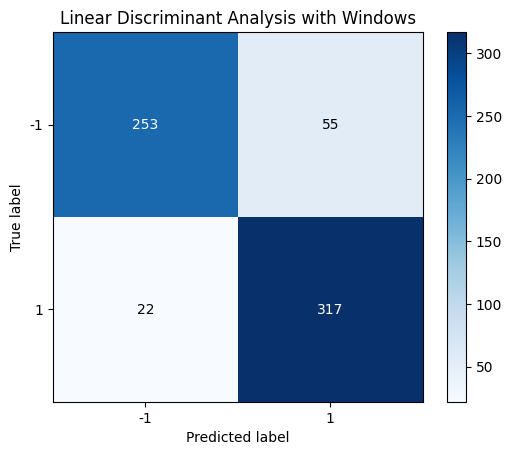

In [ ]:
plot_confusion_matrix(y_test_c, LDAW_predict, title="Linear Discriminant Analysis with Windows")

<Axes: title={'center': 'Quadratic Discriminant Analysis with Windows'}, xlabel='Predicted label', ylabel='True label'>

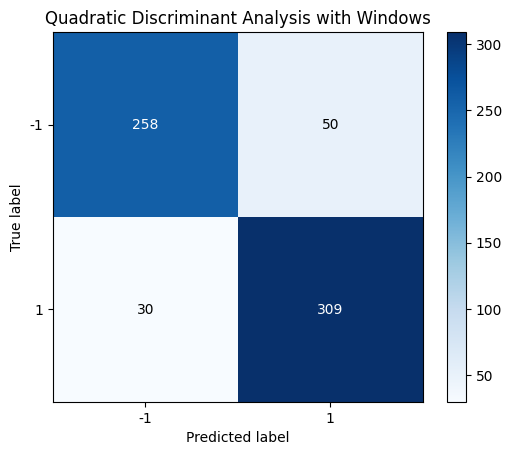

In [ ]:
plot_confusion_matrix(y_test_c, QDAW_predict, title="Quadratic Discriminant Analysis with Windows")

In [ ]:
print(classification_report(y_test_c, LDAW_predict))

              precision    recall  f1-score   support

          -1       0.92      0.82      0.87       308
           1       0.85      0.94      0.89       339

    accuracy                           0.88       647
   macro avg       0.89      0.88      0.88       647
weighted avg       0.88      0.88      0.88       647



In [ ]:
print(classification_report(y_test_c, QDAW_predict))

              precision    recall  f1-score   support

          -1       0.90      0.84      0.87       308
           1       0.86      0.91      0.89       339

    accuracy                           0.88       647
   macro avg       0.88      0.87      0.88       647
weighted avg       0.88      0.88      0.88       647



In [ ]:
Pkl_Filename = "SingleLDA.pkl"

with open(Pkl_Filename, 'wb') as file:
    pickle.dump(LDAW_model, file)

In [ ]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import accuracy_score


In [ ]:
lda = LinearDiscriminantAnalysis()
bagging_clf = BaggingClassifier(base_estimator=lda, n_estimators=500, random_state=42)


In [ ]:
bagging_clf.fit(x_train_c, y_train_c)


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


BaggingClassifier(base_estimator=LinearDiscriminantAnalysis(), n_estimators=500,
                  random_state=42)

In [ ]:
y_pred = bagging_clf.predict(x_test_c)
accuracy = accuracy_score(y_test_c, y_pred)
print(f'Accuracy: {accuracy}')


Accuracy: 0.8825347758887172


In [ ]:
print(classification_report(y_test_c, y_pred))

              precision    recall  f1-score   support

          -1       0.92      0.83      0.87       308
           1       0.86      0.93      0.89       339

    accuracy                           0.88       647
   macro avg       0.89      0.88      0.88       647
weighted avg       0.89      0.88      0.88       647



<Axes: title={'center': 'Ensemble Discriminant Analysis with Windows'}, xlabel='Predicted label', ylabel='True label'>

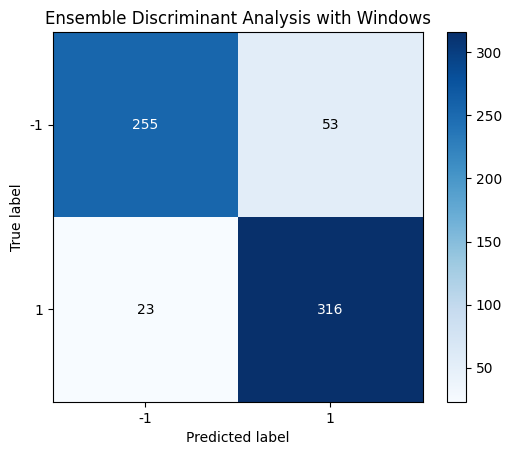

In [ ]:
plot_confusion_matrix(y_test_c, y_pred, title="Ensemble Discriminant Analysis with Windows")

In [ ]:
Pkl_Filename = "LDA_Bagging.pkl"

with open(Pkl_Filename, 'wb') as file:
    pickle.dump(bagging_clf, file)

In [2]:
import pickle
with open('/content/LDA_Bagging.pkl', 'rb') as f:
    bagging_clf = pickle.load(f)

In [3]:
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification
# Setup the FinBERT model
tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")
classifier = pipeline('sentiment-analysis', model=model, tokenizer=tokenizer, truncation=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

Here we will get some news and historical data for the period from 26 April to 2 May and see if the model can predict that the prices will go up. (These are 5 days since 27 and 28 are weekends)

You can check the news here:
https://www.bloomberg.com/search?query=DJIA

and the stock prices here:
https://finance.yahoo.com/quote/%5EDJI/history

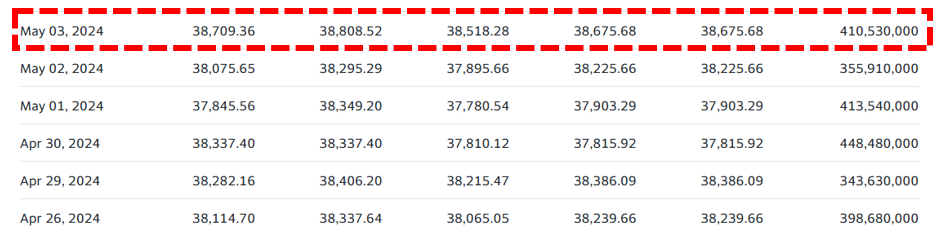

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
img_path = "/content/yahoo_external_test.png"
img = cv2.imread(img_path)
cv2_imshow(img)

In [7]:
import numpy as np


text1=["""Tech Jumps in Late Hours on Apple’s Solid Outlook: Markets Wrap
 The rally in tech heavyweights extended into late hours after better-than-estimated results from Apple Inc., with the iPhone maker also raising its dividend and announcing plans to buy back more stock.
"""]
text2=["""
Treasuries Rally With Fed Not as Hawkish as Feared: Markets Wrap
Bonds rallied after Jerome Powell downplayed the possibility of interest-rate hikes and the Federal Reserve said it will shrink its balance sheet at a slower pace to ease strains in money markets.
"""]

text3=["""Wall Street Hit by Fed Jitters to Close Wild April: Markets Wrap
The stock market sank in the final stretch of April and bond yields climbed on concern that stubborn inflation will force the Federal Reserve to keep interest rates higher for longer.
""","""
Home-Price Gains Accelerate in the US, Climbing 6.4% in February
US home-price gains accelerated in February, extending a streak of increases that has pushed many would-be buyers to the sidelines.
"""]
text4=["""Stock Bulls Look to Earnings With Fed in a Corner: Markets Wrap
Stocks rose as a solid earnings season propped up the market despite bets the Federal Reserve will keep interest rates higher for longer.
""","""
Yen Sparks Intervention Suspicion After U-Turn From 1990 Lows
The yen surged back from its weakest level against the dollar in 34 years amid speculation the Japanese government intervened to support its beleaguered currency for the first time since 2022.
""","""
Wild Swings: The Bloomberg Open, Americas Edition
Good morning. The yen has a rollercoaster ride. China clears key hurdles for Tesla’s self-driving features. And the McKinsey boss is using rap and rock to pump up morale.
"""]

text5=["""
‘AI Craze’ Powers Best Week in 2024 for Stocks: Markets Wrap
A rally in the world’s largest technology companies lifted stocks, with Wall Street also breathing a sigh of relief after the latest inflation data came roughly in line with estimates.
"""]

news = [text1,text2,text3,text4,text5]

labels = []
scores = []
for text in news:
# title_description = [text if text.strip() != '' else "No content" for text in title_description]
  temp_l = []
  for result in classifier(text):
    if result['label'] == 'positive':
      temp_l.append(1)
    elif result['label'] == 'negative':
      temp_l.append(-1)
    else:
      temp_l.append(0)
  labels.append(sum(temp_l)/len(temp_l))
      # scores.append(result['score'])

In [8]:
labels

[1.0, -1.0, 0.0, 0.6666666666666666, 1.0]

In [9]:
l = [38075.65, 38295.29, 37895.66, 355910000.0,38225.66, 1.0,
    37845.56, 38349.20, 37780.54, 413540000.0, 37903.29, -1.0,
    38337.40, 38337.40, 37810.12, 448480000.0, 37815.92, 0.0,
    38282.16, 38406.20, 38215.47, 343630000.0, 38386.09, 0.66,
    38114.70, 38337.64, 38065.05, 398680000.0,38239.66	,1.0]
l = np.array(l)
l = l.reshape(1,-1)
l

array([[ 3.807565e+04,  3.829529e+04,  3.789566e+04,  3.559100e+08,
         3.822566e+04,  1.000000e+00,  3.784556e+04,  3.834920e+04,
         3.778054e+04,  4.135400e+08,  3.790329e+04, -1.000000e+00,
         3.833740e+04,  3.833740e+04,  3.781012e+04,  4.484800e+08,
         3.781592e+04,  0.000000e+00,  3.828216e+04,  3.840620e+04,
         3.821547e+04,  3.436300e+08,  3.838609e+04,  6.600000e-01,
         3.811470e+04,  3.833764e+04,  3.806505e+04,  3.986800e+08,
         3.823966e+04,  1.000000e+00]])

In [18]:
external_pred = bagging_clf.predict(l)
if list(external_pred)[0] == 1:
  print("The prices will probably go UP or maybe stay the same")
else:
  print("The prices will probably go DOWN")

The prices will probably go UP or maybe stay the same


We can see that the model predicted that the prices will go up (predicted '1') and the prices did go up

* What interesting is that this is the first try. I have chosen this period since the prices went up considerably (around 700$).

# Let's make it a bit challenging!
let's try to predict the most recent data on Yahoo Finance. The last data was published on the website is on May/28/2024.

Although the price for this day went down just a little, it's worth to see how the model will perform

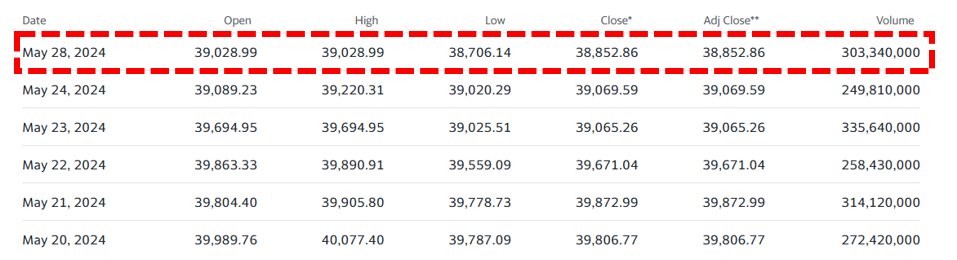

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
img_path = "/content/last_prices.png"
img = cv2.imread(img_path)
cv2_imshow(img)

In [19]:
text1 = ["""
Stocks Rise on Hopes Inflation Pressures Will Ease: Markets Wrap
Stocks rose after data showed American consumers tempered inflation expectations, bolstering sentiment regarding prospects for Federal Reserve rate-cuts this year.
"""]

text2 = ["""Boeing China Deliveries Halted Just Months After They Resumed
Just months after ending a five-year hiatus, Boeing Co. has again stopped delivering airplanes to customers in China, a fresh roadblock in the company’s push to restore its battered reputation.""",
"""Stocks Join Bonds in Falling as Fed-Cut Bets Wane: Markets Wrap
Stocks and bonds retreated as data showing US business activity accelerated amid a pickup in inflation reinforced bets the Federal Reserve will remain on hold."""]

text3 = ["""
S&P 500 Companies Adjust GAAP Net Income for More Items, Boost EPS
Large US companies are bolstering their adjusted earnings per share by excluding items such as litigation expenses and amortization of intangible assets from their net income, even as regulators scrutinize such practices, a new analysis finds."""]

text4 = [""] # There's no news for this day

text5 = ["""Dow Jones Industrial Average 40,000 Milestone Is Part of Stock Boom
Some market watchers see big gains ahead. Plus: How Netflix fixed its password problem."""]

news = [text1,text2,text3,text4,text5]

labels = []
scores = []
for text in news:
# title_description = [text if text.strip() != '' else "No content" for text in title_description]
  temp_l = []
  for result in classifier(text):
    if result['label'] == 'positive':
      temp_l.append(1)
    elif result['label'] == 'negative':
      temp_l.append(-1)
    else:
      temp_l.append(0)
  labels.append(sum(temp_l)/len(temp_l))


In [20]:
labels

[1.0, -1.0, 1.0, 0.0, 0.0]

In [21]:
# May 24, 2024	39,089.23	39,220.31	39,020.29	39,069.59	39,069.59	249,810,000
# May 23, 2024	39,694.95	39,694.95	39,025.51	39,065.26	39,065.26	335,640,000
# May 22, 2024	39,863.33	39,890.91	39,559.09	39,671.04	39,671.04	258,430,000
# May 21, 2024	39,804.40	39,905.80	39,778.73	39,872.99	39,872.99	314,120,000
# May 20, 2024	39,989.76	40,077.40	39,787.09	39,806.77	39,806.77	272,420,000

l = [39089.23, 39220.31, 39020.29,39069.59, 249810000.0, 1.0,
    39694.95, 39694.95, 39025.51, 39065.26, 335640000.0, -1.0,
    39863.33, 39890.91, 39559.09, 39671.04, 258430000.0, 1.0,
    39804.40, 39905.80, 39778.73,	39872.99, 314120000.0, 0.0,
    39989.76, 40077.40, 39787.09, 39806.77,272420000	,0.0]
l = np.array(l)
l = l.reshape(1,-1)
l

array([[ 3.908923e+04,  3.922031e+04,  3.902029e+04,  3.906959e+04,
         2.498100e+08,  1.000000e+00,  3.969495e+04,  3.969495e+04,
         3.902551e+04,  3.906526e+04,  3.356400e+08, -1.000000e+00,
         3.986333e+04,  3.989091e+04,  3.955909e+04,  3.967104e+04,
         2.584300e+08,  1.000000e+00,  3.980440e+04,  3.990580e+04,
         3.977873e+04,  3.987299e+04,  3.141200e+08,  0.000000e+00,
         3.998976e+04,  4.007740e+04,  3.978709e+04,  3.980677e+04,
         2.724200e+08,  0.000000e+00]])

In [23]:
external_pred = bagging_clf.predict(l)
if list(external_pred)[0] == 1:
  print("The prices will probably go UP or maybe stay the same")
else:
  print("The prices will probably go DOWN")

The prices will probably go DOWN


**What interesting here is that even though only one of the headlines is negative (it's not even the last day), the model could predict that the prices will go down. In my opinion, I noticed that there's kind of a pattern of the news when the prices will go down. Usually there's kind of silence with some fluctuation of neutral, positive, bad news. but I found that the major factor is the 'silence'. And, indeed, we can see that we have 2 neutral news .. and there's a day without news at all.**